# Statistical Analysis of Image Deblurring Methods

This notebook analyzes the performance of different deblurring methods (Pseudoinverse, Wiener, DeblurGANv2) using a comprehensive statistical approach. We will explore descriptive statistics, hypothesis testing, confidence intervals, regression analysis, and visualizations to understand the strengths and weaknesses of each method.

In [1]:
# Load all datasets
import pandas as pd

from common.config import IDPA_DATASET, WIENER_NOKERNEL_DATASET, WIENER_WKERNEL_DATASET, DEBLURGANV2_DATASET

original_df = pd.read_parquet(IDPA_DATASET)
wiener_nokernel_df = pd.read_parquet(WIENER_NOKERNEL_DATASET)
wiener_wkernel_df = pd.read_parquet(WIENER_WKERNEL_DATASET)
deblurganv2_df = pd.read_parquet(DEBLURGANV2_DATASET)

# Merge metrics with original features
dfs = {
    'wiener_nokernel': wiener_nokernel_df,
    'wiener_wkernel': wiener_wkernel_df,
    'deblurganv2': deblurganv2_df
}
for k in dfs:
    dfs[k] = original_df.merge(dfs[k], on='key')

## 0. Comparison: Wiener No-Kernel vs Wiener With-Kernel

We first compare the two Wiener approaches to decide which to use for further analysis. We examine the correlation and average metrics across blur types.

In [ ]:
# DATA EXPLORATION
# TODO 1: compare wiener no-kernel and wiener with-kernel for each metric using pairplot and boxplots (4 box plots each representing with/no kernel), *correlation heatmap
# explain outliers: 
# - some pictures have mostly the same color which results in good restoration
# - some pictures are very high resolution, but the range of the blur was fixed, so the general blur is weaker for high resolution images

# HYPOTHESIS TESTING (LPIPS)
# TODO 2: AI vs Classical methods (giorgio)
# TODO 3: Motion blur angle > 180° vs ≤ 180° (giorgio)
# TODO 4: High vs Low Contrast (> 0.25 threshold) (We defined 0.25 as threshold for contrast from internet article)

# CONFIDENCE INTERVAL
# TODO 5: For each of the hypothesis tests that was successfull

# LINEAR REGRESSION
# TODO 6: 

# MULTIPLE LINEAR REGRESSION
# TODO 5: (giorgio)


boxplot of feature (once more with outliers removed) (explain why outliers exist)
qq-plot (explain why outliers exist)
hypothesis test on avg (why value was chosen) (IDEA: check deblurgan results)

confidence = .95 only when small sample, otherwise better to have .99 or .999

check consistency of hypothesis test with confidence interval

SyntaxError: invalid syntax (2203727253.py, line 23)

Correlation of ssim_avg between wiener_nokernel and wiener_wkernel: 0.817
Correlation of psnr_avg between wiener_nokernel and wiener_wkernel: 0.786
Correlation of lpips_avg between wiener_nokernel and wiener_wkernel: 0.724
Correlation of gmsd_avg between wiener_nokernel and wiener_wkernel: 0.824
ssim_avg: wiener_nokernel=0.274, wiener_wkernel=0.283
psnr_avg: wiener_nokernel=15.540, wiener_wkernel=15.171
lpips_avg: wiener_nokernel=0.127, wiener_wkernel=0.095
gmsd_avg: wiener_nokernel=0.273, wiener_wkernel=0.258


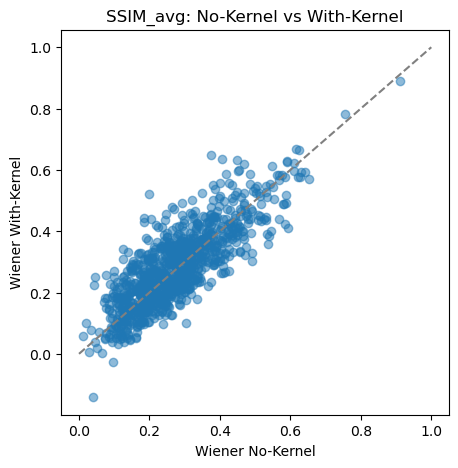

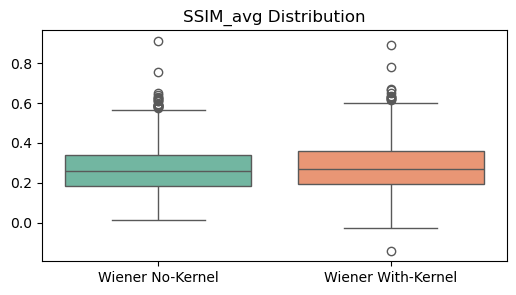

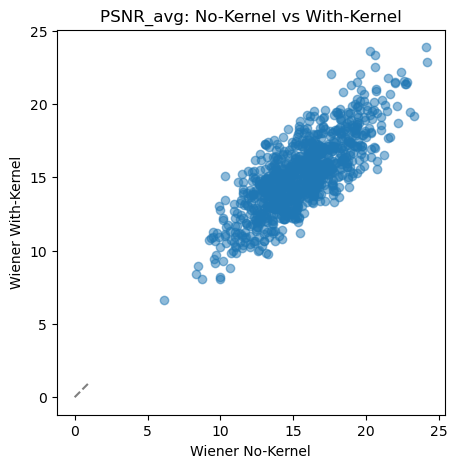

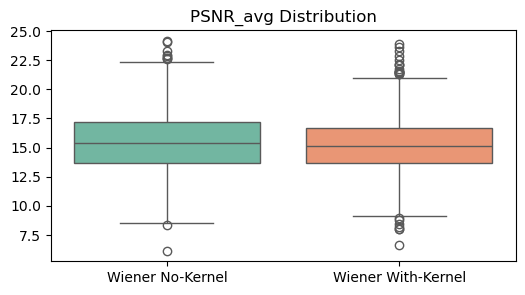

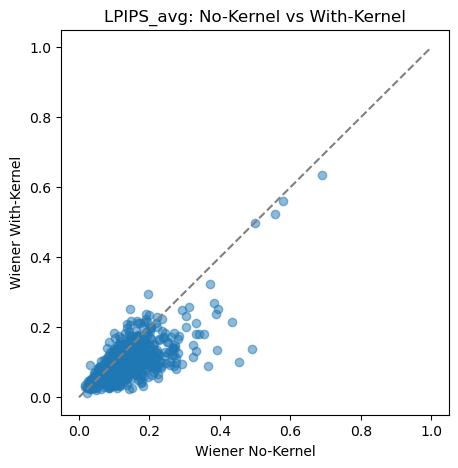

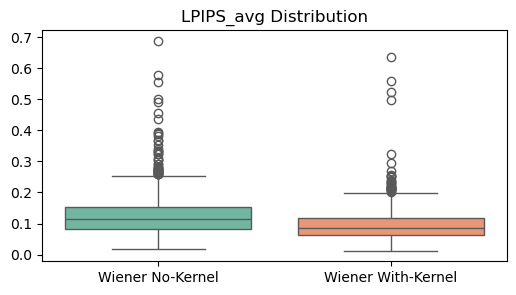

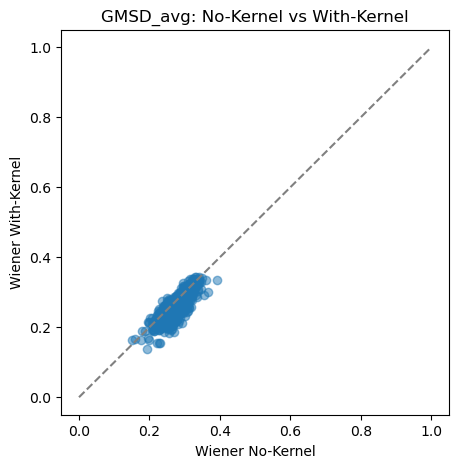

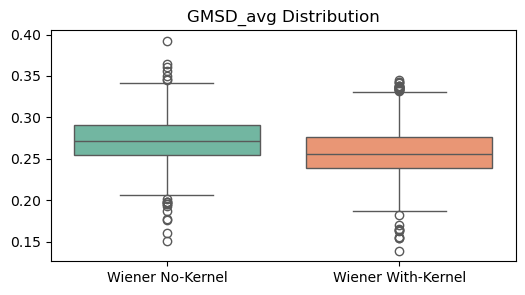

In [2]:
# Compare wiener_nokernel and wiener_wkernel: correlation and mean metrics
import numpy as np

metric_types = ['ssim', 'psnr', 'lpips', 'gmsd']
blur_types = ['box', 'gaussian', 'motion']

# Compute average metric across blur types for each approach
for df in [dfs['wiener_nokernel'], dfs['wiener_wkernel']]:
    for metric in metric_types:
        cols = [f'{metric}_{b}' for b in blur_types if f'{metric}_{b}' in df.columns]
        df[f'{metric}_avg'] = df[cols].mean(axis=1)

# Correlation between avg metrics
for metric in metric_types:
    corr = dfs['wiener_nokernel'][f'{metric}_avg'].corr(dfs['wiener_wkernel'][f'{metric}_avg'])
    print(f'Correlation of {metric}_avg between wiener_nokernel and wiener_wkernel: {corr:.3f}')

# Compare means
for metric in metric_types:
    mean_nk = dfs['wiener_nokernel'][f'{metric}_avg'].mean()
    mean_wk = dfs['wiener_wkernel'][f'{metric}_avg'].mean()
    print(f'{metric}_avg: wiener_nokernel={mean_nk:.3f}, wiener_wkernel={mean_wk:.3f}')

# Visualize scatter and boxplots
import matplotlib.pyplot as plt
import seaborn as sns
for metric in metric_types:
    plt.figure(figsize=(5,5))
    plt.scatter(dfs['wiener_nokernel'][f'{metric}_avg'], dfs['wiener_wkernel'][f'{metric}_avg'], alpha=0.5)
    plt.xlabel('Wiener No-Kernel')
    plt.ylabel('Wiener With-Kernel')
    plt.title(f'{metric.upper()}_avg: No-Kernel vs With-Kernel')
    plt.plot([0,1],[0,1],'--',color='gray')
    plt.show()

    plt.figure(figsize=(6,3))
    # Use a DataFrame for seaborn boxplot to ensure both are shown
    plot_df = pd.DataFrame({
        'Wiener No-Kernel': dfs['wiener_nokernel'][f'{metric}_avg'],
        'Wiener With-Kernel': dfs['wiener_wkernel'][f'{metric}_avg']
    })
    sns.boxplot(data=plot_df, palette='Set2')
    plt.title(f'{metric.upper()}_avg Distribution')
    plt.show()

Based on the above, we proceed with **Wiener With-Kernel** for further analysis.

In [3]:
# Prepare dfs for further analysis: only wiener_wkernel and deblurganv2
dfs = {
    'wiener': dfs['wiener_wkernel'],
    'deblurganv2': dfs['deblurganv2']
}

# Compute avg metrics for each method
for df in dfs.values():
    for metric in metric_types:
        cols = [f'{metric}_{b}' for b in blur_types if f'{metric}_{b}' in df.columns]
        df[f'{metric}_avg'] = df[cols].mean(axis=1)

## 1. Descriptive Statistics (Average Metrics)

We summarize the distributions of image features and average deblurring metrics for each method.

In [4]:
feature_cols = ['width', 'height', 'aspect_ratio', 'sobel_edge_strength', 'canny_edge_density', 'rms_contrast',
                'box_size', 'gaussian_size', 'gaussian_sigma', 'motion_length', 'motion_angle']

for method, df in dfs.items():
    print(f'===== {method.upper()} =====')
    print('Image features:')
    print(df[feature_cols].describe().T)
    print('Average metrics:')
    print(df[[f'{m}_avg' for m in metric_types]].describe().T)

===== WIENER =====
Image features:
                     count         mean         std         min          25%  \
width                950.0  1556.865263  461.015906  170.000000  1223.000000   
height               950.0  1361.677895  434.723050  117.000000  1080.000000   
aspect_ratio         950.0     1.215505    0.383402    0.463392     0.800500   
sobel_edge_strength  950.0    63.759947   25.274638    8.266673    45.575302   
canny_edge_density   950.0     0.128991    0.057644    0.000000     0.088474   
rms_contrast         950.0     0.241307    0.054723    0.060424     0.204291   
box_size             950.0    10.117895    3.151395    5.000000     7.000000   
gaussian_size        950.0    13.461053    5.549477    5.000000     9.000000   
gaussian_sigma       950.0     2.199617    0.995533    0.515940     1.348071   
motion_length        950.0    17.590526    7.629577    5.000000    11.000000   
motion_angle         950.0   183.191937  103.763953    0.618597    91.414728   

    

## 2. Visualizations (Average Metrics)

Visualize the distributions and relationships of average metrics and features.

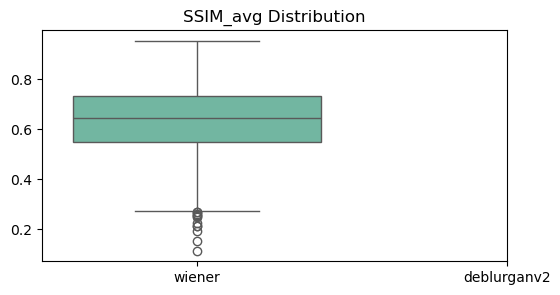

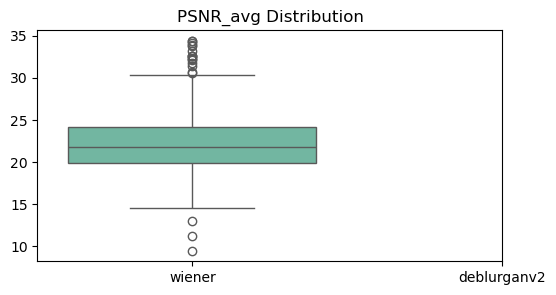

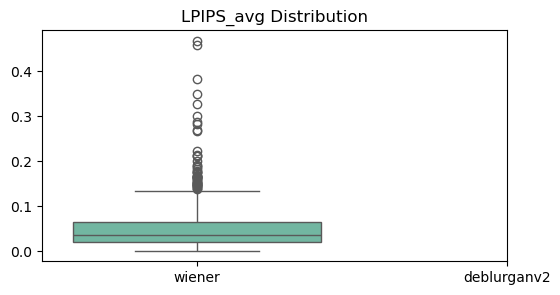

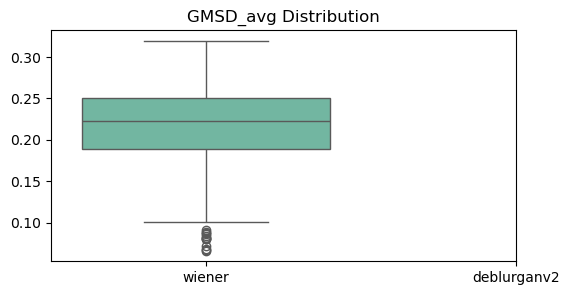

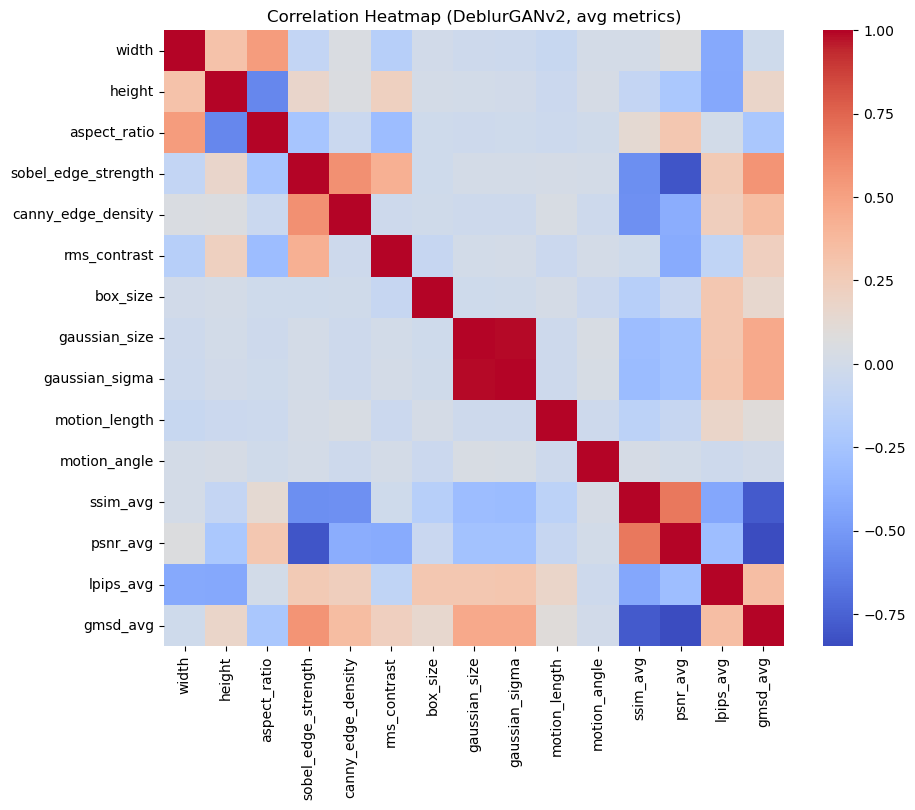

In [5]:
# Boxplots for each avg metric
for metric in metric_types:
    plt.figure(figsize=(6,3))
    data = [df[f'{metric}_avg'] for df in dfs.values()]
    labels = list(dfs.keys())
    sns.boxplot(data=data, palette='Set2')
    plt.xticks(ticks=range(len(labels)), labels=labels)
    plt.title(f'{metric.upper()}_avg Distribution')
    plt.show()

# Correlation heatmap for features and avg metrics (example: DeblurGANv2)
corr_cols = feature_cols + [f'{m}_avg' for m in metric_types]
corr = dfs['deblurganv2'][corr_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap (DeblurGANv2, avg metrics)')
plt.show()

## 3. Hypothesis Testing and Power Analysis (Average Metrics)

Compare the performance of methods using paired tests on average metrics.

In [6]:
from scipy.stats import ttest_rel, wilcoxon
from statsmodels.stats.power import TTestPower

def paired_test(df1, df2, metric_col):
    mask = df1[metric_col].notna() & df2[metric_col].notna()
    x, y = df1.loc[mask, metric_col], df2.loc[mask, metric_col]
    t_stat, t_p = ttest_rel(x, y)
    try:
        w_stat, w_p = wilcoxon(x, y)
    except:
        w_stat, w_p = np.nan, np.nan
    return t_stat, t_p, w_stat, w_p, len(x)

for metric in metric_types:
    col = f'{metric}_avg'
    t_stat, t_p, w_stat, w_p, n = paired_test(dfs['deblurganv2'], dfs['wiener'], col)
    print(f'{col} (DeblurGANv2 vs Wiener): t-test p={t_p:.4g}, Wilcoxon p={w_p:.4g}, n={n}')
    effect = (dfs['deblurganv2'][col].mean() - dfs['wiener'][col].mean()) / dfs['deblurganv2'][col].std()
    power = TTestPower().power(effect_size=abs(effect), nobs=n, alpha=0.05)
    print(f'  Power: {power:.3f}')

ssim_avg (DeblurGANv2 vs Wiener): t-test p=0, Wilcoxon p=4.743e-157, n=950
  Power: 1.000
psnr_avg (DeblurGANv2 vs Wiener): t-test p=0, Wilcoxon p=4.743e-157, n=950
  Power: 1.000
lpips_avg (DeblurGANv2 vs Wiener): t-test p=7.554e-188, Wilcoxon p=4.381e-134, n=950
  Power: nan
gmsd_avg (DeblurGANv2 vs Wiener): t-test p=1.096e-143, Wilcoxon p=3.957e-112, n=950
  Power: nan


## 4. Confidence Intervals (Average Metrics)

Compute 95% confidence intervals for the mean of each average metric.

In [7]:
import scipy.stats as stats

def mean_ci(series, alpha=0.05):
    n = series.notna().sum()
    m = series.mean()
    se = series.std(ddof=1) / np.sqrt(n)
    h = stats.t.ppf(1 - alpha/2, n-1) * se
    return m, m-h, m+h

for method, df in dfs.items():
    print(f'--- {method} ---')
    for metric in metric_types:
        col = f'{metric}_avg'
        m, lb, ub = mean_ci(df[col])
        print(f'{col}: mean={m:.3f}, 95% CI=({lb:.3f}, {ub:.3f})')

--- wiener ---
ssim_avg: mean=0.283, 95% CI=(0.275, 0.291)
psnr_avg: mean=15.171, 95% CI=(15.011, 15.331)
lpips_avg: mean=0.095, 95% CI=(0.092, 0.099)
gmsd_avg: mean=0.258, 95% CI=(0.256, 0.260)
--- deblurganv2 ---
ssim_avg: mean=0.635, 95% CI=(0.626, 0.644)
psnr_avg: mean=22.103, 95% CI=(21.890, 22.316)
lpips_avg: mean=0.050, 95% CI=(0.047, 0.053)
gmsd_avg: mean=0.217, 95% CI=(0.214, 0.220)


## 5. Linear Regression Analysis (Average Metrics)

Model the relationship between image features/blur parameters and average deblurring metrics. Visualize regression fit and residuals.

                            OLS Regression Results                            
Dep. Variable:               ssim_avg   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     104.6
Date:                Wed, 21 May 2025   Prob (F-statistic):          1.36e-154
Time:                        08:41:31   Log-Likelihood:                 916.48
No. Observations:                 950   AIC:                            -1809.
Df Residuals:                     938   BIC:                            -1751.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.8432    

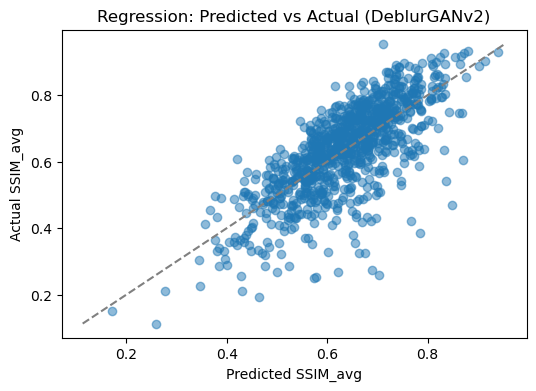

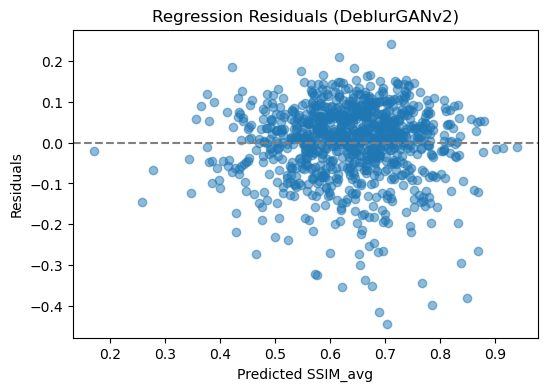

In [8]:
import statsmodels.api as sm

# Example: Predict SSIM_avg for DeblurGANv2
target = 'ssim_avg'
X = dfs['deblurganv2'][feature_cols]
X = sm.add_constant(X)
y = dfs['deblurganv2'][target]
model = sm.OLS(y, X, missing='drop').fit()
print(model.summary())

# Visualization: predicted vs actual, residuals
y_pred = model.predict(X)
plt.figure(figsize=(6,4))
plt.scatter(y_pred, y, alpha=0.5)
plt.xlabel('Predicted SSIM_avg')
plt.ylabel('Actual SSIM_avg')
plt.title('Regression: Predicted vs Actual (DeblurGANv2)')
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='gray')
plt.show()

residuals = y - y_pred
plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Predicted SSIM_avg')
plt.ylabel('Residuals')
plt.title('Regression Residuals (DeblurGANv2)')
plt.show()

## 6. Conclusions

Summarize the main findings from the descriptive statistics, hypothesis tests, confidence intervals, and regression analysis. Discuss which methods perform best under which conditions, and which image features or blur parameters are most predictive of deblurring success.